# **Week-4**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.appName("ETL").getOrCreate()
spark

#  Uploading cleaned data to Databricks

In [16]:
from google.colab import files
uploaded = files.upload()

Saving employees.csv to employees (1).csv
Saving products.csv to products (1).csv
Saving sales.csv to sales (1).csv
Saving stores.csv to stores (1).csv


In [18]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ColabSpark").getOrCreate()

dfEmp = spark.read.csv("/content/employees.csv", header=True, inferSchema=True)
dfPro = spark.read.csv("/content/products.csv", header=True, inferSchema=True)
dfSal = spark.read.csv("/content/sales.csv", header=True, inferSchema=True)
dfSto = spark.read.csv("/content/stores.csv", header=True, inferSchema=True)

In [10]:
dfEmp.printSchema()

root
 |-- employeeid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- storeid: integer (nullable = true)
 |-- role: string (nullable = true)
 |-- hiredate: string (nullable = true)



In [11]:
dfPro.printSchema()

root
 |-- productid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- cost: double (nullable = true)
 |-- discountpercentage: integer (nullable = true)
 |-- createdat: string (nullable = true)



In [12]:
dfSal.printSchema()

root
 |-- saleid: integer (nullable = true)
 |-- productid: integer (nullable = true)
 |-- storeid: integer (nullable = true)
 |-- employeeid: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- saledate: string (nullable = true)



In [13]:
dfSto.printSchema()

root
 |-- storeid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- region: string (nullable = true)
 |-- address: string (nullable = true)
 |-- createdat: string (nullable = true)



# Transforming and joining product + sales data

In [19]:
dfProSales = dfPro.join(dfSal, on="productID", how="inner")

In [22]:
dfProSales = dfProSales.withColumn("daysToSell",F.datediff(F.col("saledate"), F.col("createdat")))

In [27]:
from pyspark.sql import functions as F

# Calculate Margin and Margin %
dfProSales = dfProSales.withColumn("Margin", F.col("price") - F.col("cost")).withColumn("MarginPct", ((F.col("price") - F.col("cost")) / F.col("price")) * 100)

# Now aggregate
categoryReport = dfProSales.groupBy("category").agg(
    F.round(F.mean("MarginPct"), 2).alias("averageMarginPct"),
    F.round(F.mean("daysToSell"), 2).alias("averageDaysTakesToSell"),
    F.round(F.mean("Margin"), 2).alias("averageMarginINR"),
    F.round(F.mean("quantity"), 2).alias("averageQTYperBuy"),
    F.sum("quantity").alias("totalQuantitySold"))
categoryReport.show()


+-----------+----------------+----------------------+----------------+----------------+-----------------+
|   category|averageMarginPct|averageDaysTakesToSell|averageMarginINR|averageQTYperBuy|totalQuantitySold|
+-----------+----------------+----------------------+----------------+----------------+-----------------+
|    apparel|           44.36|                  NULL|            21.0|            12.4|               62|
| home goods|           42.73|                  NULL|            10.5|             7.5|               30|
|    grocery|            38.9|                  NULL|            1.78|            28.0|              140|
|electronics|            25.4|                  NULL|          154.83|            4.33|               26|
+-----------+----------------+----------------------+----------------+----------------+-----------------+



# Saving final metrics

In [29]:
from google.colab import drive
drive.mount('/content/drive')

categoryReport.coalesce(1).write.mode("overwrite").csv("/content/drive/MyDrive/categoryReport", header=True)

Mounted at /content/drive


# Databricks SQL cell to find top 3 best-selling products

In [30]:
spark.sql("CREATE DATABASE product_sales")
spark.sql("USE product_sales")

DataFrame[]

In [31]:
dfProSales.write.mode("overwrite").saveAsTable("product_sales.pro_sales")

In [32]:
prodReport = spark.sql("""SELECT productID, name, SUM(quantity) AS SoldQty, SUM(Margin * quantity) AS RevenueGenerated FROM pro_sales
GROUP BY productID, name
ORDER BY SUM(quantity) DESC
LIMIT 3""")
prodReport.show()

+---------+---------------+-------+----------------+
|productID|           name|SoldQty|RevenueGenerated|
+---------+---------------+-------+----------------+
|        2|organic bananas|    122|           122.0|
|        3|    denim jeans|     36|           720.0|
|        5|  led desk lamp|     21|           210.0|
+---------+---------------+-------+----------------+



# Deliverables
###Databricks notebook with ETL logic
###Saved output files for dashboard use

In [ ]:
# 1. databricks notebook is saved in .ipynb format in week-4 of project in git repo

In [35]:
prodReport.coalesce(1).write.mode("overwrite").csv("/content/drive/MyDrive/productMetrics", header=True)
categoryReport.coalesce(1).write.mode("overwrite").csv("/content/drive/MyDrive/categoryMetrics", header=True)

In [37]:
import shutil
import os

# For prodReport
prod_csv_file = [f for f in os.listdir("/content/drive/MyDrive/productMetrics") if f.startswith("part-")][0]
shutil.copy(f"/content/drive/MyDrive/productMetrics/{prod_csv_file}", "/content/drive/MyDrive/prodReport.csv")

# For categoryReport
cat_csv_file = [f for f in os.listdir("/content/drive/MyDrive/categoryMetrics") if f.startswith("part-")][0]
shutil.copy(f"/content/drive/MyDrive/categoryMetrics/{cat_csv_file}", "/content/drive/MyDrive/categoryReport.csv")

'/content/drive/MyDrive/categoryReport.csv'

# Visualization

In [39]:
visual_1 = prodReport.toPandas()
visual_2 = categoryReport.toPandas()

<Axes: xlabel='name'>

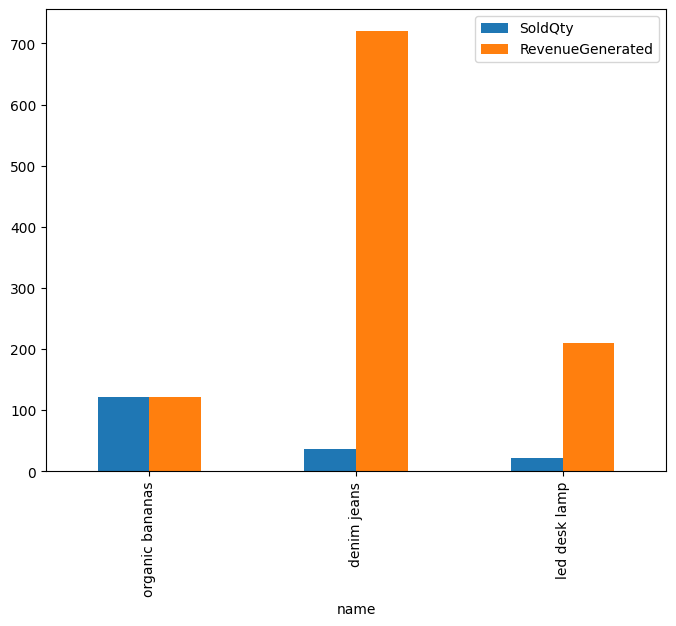

In [40]:
visual_1.plot.bar(x="name", y=["SoldQty", "RevenueGenerated"], figsize=(8, 6))

<Axes: xlabel='category'>

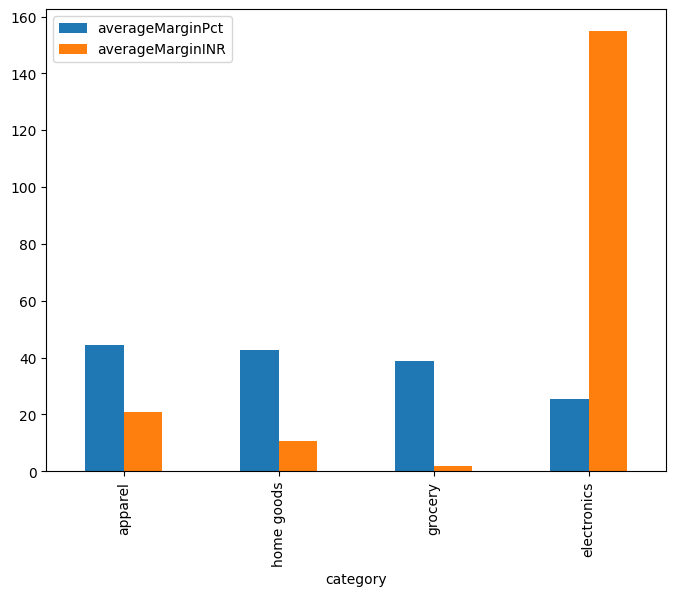

In [45]:
visual_2.plot.bar(x="category", y=["averageMarginPct", "averageMarginINR"], figsize=(8, 6))

<Axes: xlabel='category'>

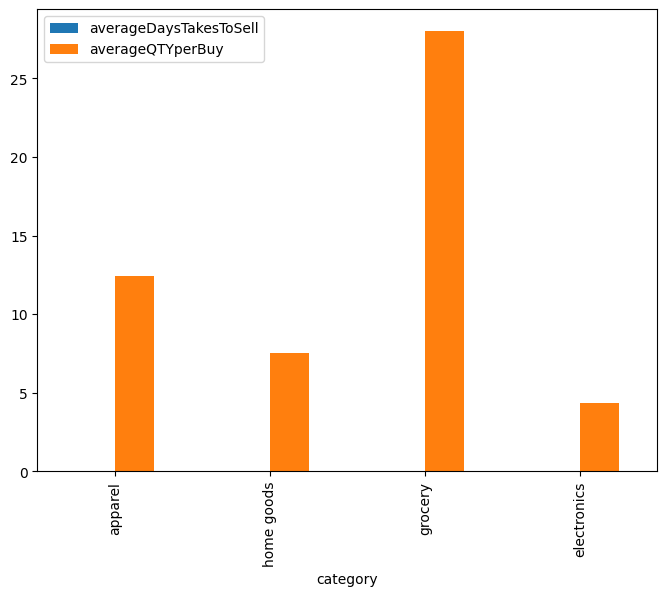

In [46]:
visual_2.plot.bar(x="category", y=["averageDaysTakesToSell", "averageQTYperBuy"], figsize=(8, 6))

<Axes: ylabel='totalQuantitySold'>

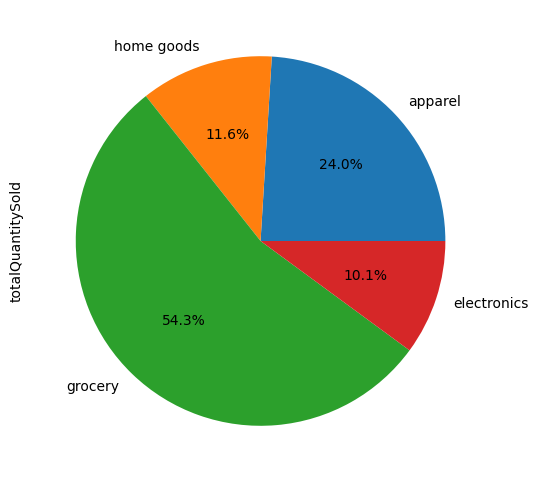

In [48]:
visual_2.set_index("category")["totalQuantitySold"].plot.pie(autopct="%1.1f%%", figsize=(8, 6))